# Scale Transform Magnitude for rythimic patterns analysis.

This notebook is based on the methodology proposed in:

- _Holzapfel, A., & Stylianou, Y. (2010). Scale transform in rhythmic similarity of music. IEEE transactions on audio, speech, and language processing, 19(1), 176-185._

### Description

The Scale Transform Magnitude (STM) is a descriptor suitable for analyzing rhythmic patterns _without_ relying on beat or downbeat annotations. STM is scale invariant, therefore it is appropriate for comparing pieces with varying tempi.

This notebook serves as a demonstration of the steps involved in computing the STM feature.

### Content

- Load short extract of audio together with its scaled up version
- Compute STFT
- Decompose spectogram to separate harmonic from percussive components
- Map percussive spectrogram onto mel frequency bands
- Compute the onset strenght signal (OSS) on the percussive mel-spectrogram 
- Compute the autocorrelation of the OSS
- Compute the scale transform magnitude (STM) on the autocorrelation of the OSS


In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from numpy.linalg import norm

### Load audio files and decompose spectrograms

The original audio file is a 10-second excerpt from the Malia Jembe dataset (Polak, R., Tarsitani, S., & Clayton, M. (2018). IEMP Malian jembe. Open Science Framework.Polak, R., Tarsitani, S., & Clayton, M. (2018). IEMP Malian jembe. Open Science Framework.).

The scaled version consists of the original signal, which has been sped up by 15% using Audacity.


In [2]:
# path to audio file
audio_file = "clip-MJ_Maraka_1_J1.wav"
# the scaled up version has been obtained using audacity to change the tempo of 15%
audio_file_scaled = "clip-MJ_Maraka_1_J1-scaled-up.wav"

y, sr = librosa.load(audio_file)
y_scaled, sr = librosa.load(audio_file_scaled)

print("original version")
ipd.display(ipd.Audio(y, rate=sr))

print("15% speeded up version")
ipd.display(ipd.Audio(y_scaled, rate=sr))

original version


15% speeded up version


We set constants for window size (1024 samples, 46ms) and hop size (256 samples, 11ms) to compute the Short-Time Fourier Transform (STFT) of the audio signal.
The sampling rate is 22,050 Hz and the window type is "hann": these are default parameters used by librosa.

Next, we compute the STFT and decompose the resulting spectrogram into harmonic and percussive components using median filtering. We map the obtained percussive spectrogram onto mel-frequency bands.

Finally, the amplitude of the percussive Mel spectrogram is converted to decibels (dB) resulting in a log-power mel spectogram which will be used as input by the onset strength signal function.

Open Questions:
- how many n_mels?

[Text(0.5, 1.0, 'Mel-frequency percussive spectrogram')]

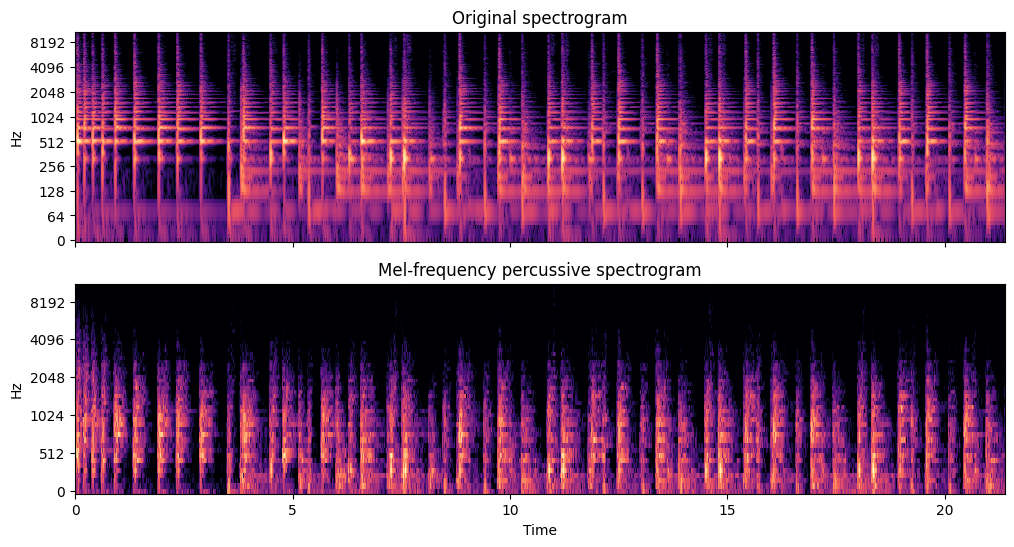

In [3]:
window_size = 1024  
hop_size = 256

# STFT and decompose original signal
spec = librosa.stft(y, win_length=window_size, hop_length=hop_size)
harm, percussive = librosa.decompose.hpss(spec)

# STFT and decompose scaled signal
spec_scaled = librosa.stft(y_scaled, win_length=window_size, hop_length=hop_size)
harm_scaled, percu_scaled = librosa.decompose.hpss(spec_scaled)

# map frequency bins onto mel scale
percussive_mel = librosa.feature.melspectrogram(S=percussive, sr=sr, n_mels=50)
percussive_mel_scaled = librosa.feature.melspectrogram(S=percu_scaled, sr=sr, n_mels=50)

# Log-power spectrogram, used as input for the onset strenght signal function
percussive_mel = librosa.amplitude_to_db(np.abs(percussive_mel), ref=np.max)
percussive_mel_scaled = librosa.amplitude_to_db(np.abs(percussive_mel_scaled), ref=np.max)

# plotting original spectogram and mel-percussive
fig, ax = plt.subplots(nrows=2, figsize=(12, 6)) 
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(spec), ref=np.max), y_axis="log", x_axis="time", ax=ax[0])
ax[0].set(title="Original spectrogram")
ax[0].label_outer()
img = librosa.display.specshow(percussive_mel, x_axis="time", y_axis="mel", sr=sr, ax=ax[1])
ax[1].set(title="Mel-frequency percussive spectrogram")


### Compute Onset Strenght Signal (OSS)

Open questions:
- what's the optimal value for lag parameter?


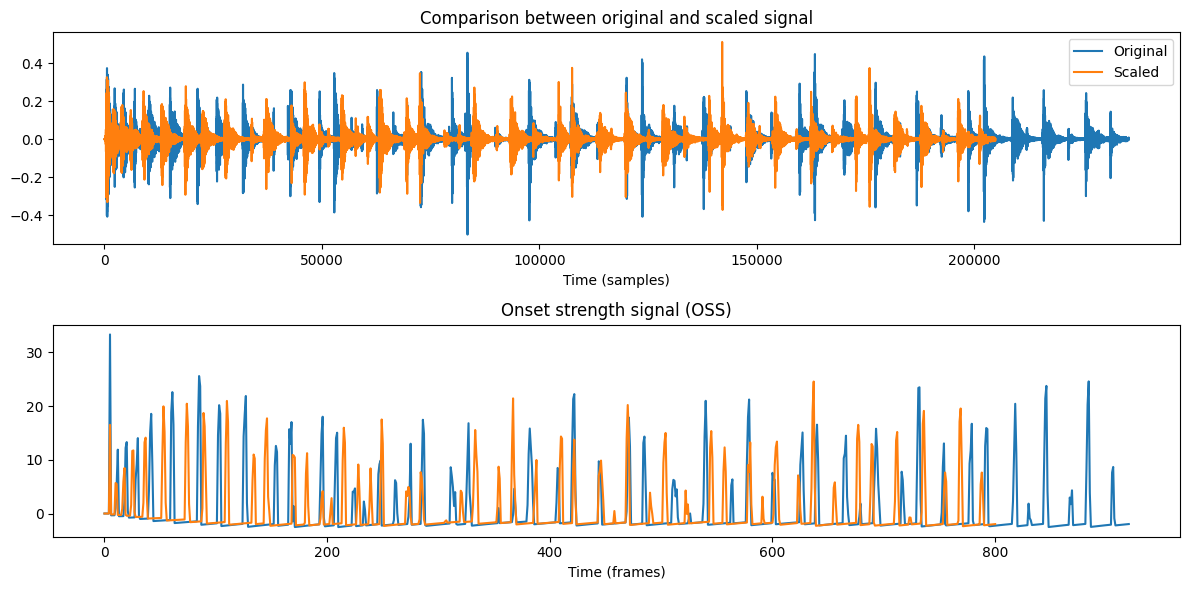

In [4]:
oss = librosa.onset.onset_strength(S=percussive_mel, lag=3, detrend=True, aggregate=np.median)
oss_scaled = librosa.onset.onset_strength(S=percussive_mel_scaled, lag=3, detrend=True, aggregate=np.median)

fig, ax = plt.subplots(nrows=2, figsize=(12, 6))

ax[0].plot(y, label="Original")

ax[0].plot(y_scaled, label="Scaled")

ax[0].set(xlabel="Time (samples)", title="Comparison between original and scaled signal")

ax[0].legend()

ax[1].plot(oss)

ax[1].plot(oss_scaled)

ax[1].set(xlabel="Time (frames)", title="Onset strength signal (OSS)")

plt.tight_layout()

From the graph above, it can be observed that the two signals exhibits a different onset strength signal (OSS). That is because the tempo of the second signal is scaled up by a factor of 15%.

In the following section, we demonstrate the invariance of the Scale Transform Magnitude (STM) to tempo changes. In other words, despite the tempo alteration, the magnitudes of the two signals remain the same.

Before proceeding with the computation of the scale transform, it's necessary to calculate the autocorrelation of the OSS. This step is crucial to overcome the fact that the STM is **not** shift-invariant.

### Compute Autocorrelation & Scale Transform Magnitude

Open questions:
- Max size for autocorrelation? Currently up to 8 seconds.
- Number of coefficients to keep from STM?


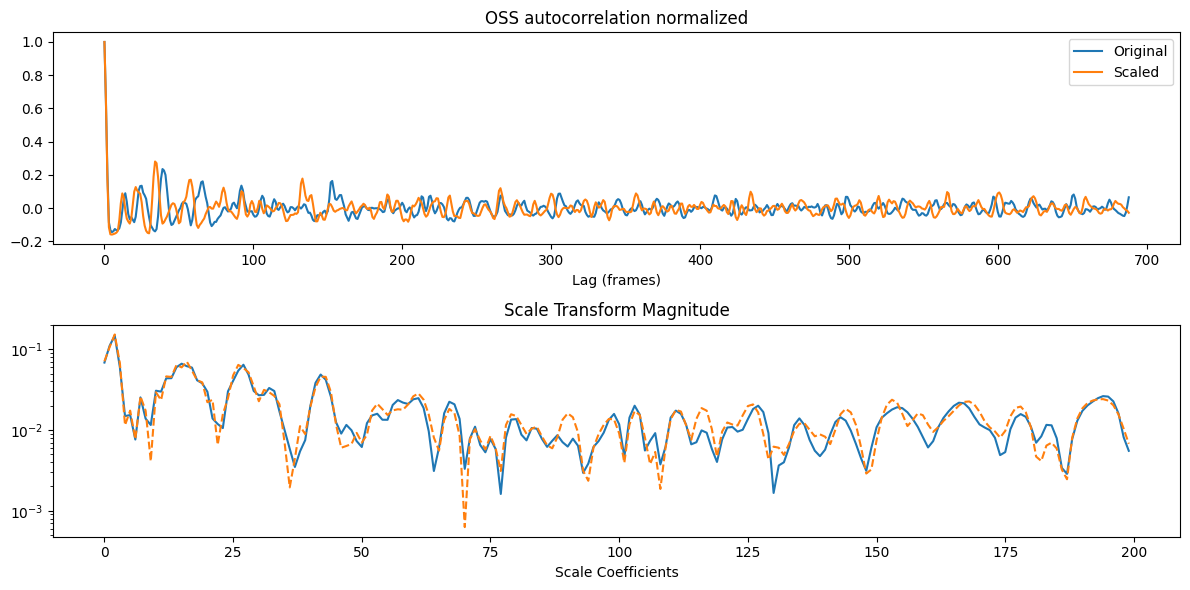

In [5]:
# auto correlation up to 8 seconds
oss_ac = librosa.autocorrelate(oss, max_size= 8 * sr // hop_size)
oss_ac_scaled = librosa.autocorrelate(oss_scaled, max_size= 8 * sr // hop_size)

# Normalization
oss_ac = librosa.util.normalize(oss_ac, norm=np.inf)
oss_ac_scaled = librosa.util.normalize(oss_ac_scaled, norm=np.inf)

# scale transform magnitude, keeping only the first 200 coeffiecients
stm = librosa.fmt(oss_ac)[:200]
stm_scaled = librosa.fmt(oss_ac_scaled)[:200]

fig, ax = plt.subplots(nrows=2, figsize=(12, 6))

ax[0].plot(oss_ac, label="Original")

ax[0].plot(oss_ac_scaled, label="Scaled")

ax[0].set(xlabel="Lag (frames)", title="OSS autocorrelation normalized")

ax[0].legend()

ax[1].semilogy(np.abs(stm))

ax[1].semilogy(np.abs(stm_scaled), linestyle="--")

ax[1].set(xlabel="Scale Coefficients", title="Scale Transform Magnitude")

plt.tight_layout()

Finally, let us compute the similarity between the 2 STMs.

We expect a high similarity score as the STM is supposed to capture rythmic aspects regardless of the tempo variations.



In [6]:
# compute cosine similarity
cosine_sim = np.dot(np.abs(stm), np.abs(stm_scaled)) / (norm(np.abs(stm)) * norm(np.abs(stm_scaled)))
print("Cosine Similarity:", cosine_sim)

# Compute Euclidean distance
euclidean_dist = np.linalg.norm(np.abs(stm) - np.abs(stm_scaled))
print("Euclidean Distance:", euclidean_dist)

Cosine Similarity: 0.9887971428560611
Euclidean Distance: 0.05284740431421972
